In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = Path('../input/obi-mouse-brain')
path.ls()

[PosixPath('../input/obi-mouse-brain/masks'),
 PosixPath('../input/obi-mouse-brain/auto tone'),
 PosixPath('../input/obi-mouse-brain/codes.txt')]

In [5]:
path_lbl = path/'masks'
path_img = path/'auto tone'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('../input/obi-mouse-brain/auto tone/AV94_DAPI.jpg'),
 PosixPath('../input/obi-mouse-brain/auto tone/BE88_DAPI.jpg'),
 PosixPath('../input/obi-mouse-brain/auto tone/BD85_DAPI.jpg')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('../input/obi-mouse-brain/masks/AV94_DAPI.jpg'),
 PosixPath('../input/obi-mouse-brain/masks/BE88_DAPI.jpg'),
 PosixPath('../input/obi-mouse-brain/masks/BD85_DAPI.jpg')]

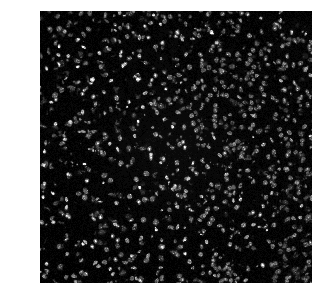

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

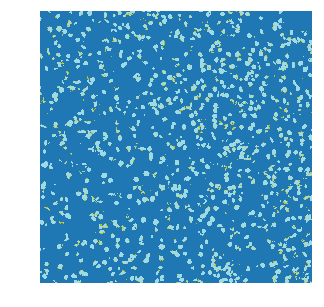

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([2048, 2048]), tensor([[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ..., 255, 255, 254],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 254, 255, 254]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Void', 'Nucleus'], dtype='<U7')

In [13]:
size = src_size//8

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [14]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['0','1']
src = (SegItemListCustom.from_folder(path_img)
       .random_split_by_pct(valid_pct=0.2, seed=33)
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [15]:
# src = (SegmentationItemList.from_folder(path_img)
#        .split_by_rand_pct(valid_pct = .2, seed = 42)
# #        .label_empty()) #TODO ???
#        .label_from_func(get_y_fn, classes=codes))

In [16]:
# data = (src.transform(get_transforms(), size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

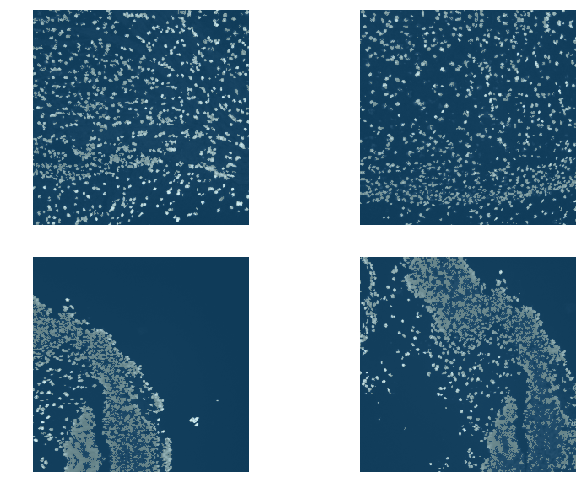

In [17]:
data.show_batch(2, figsize=(10,7))


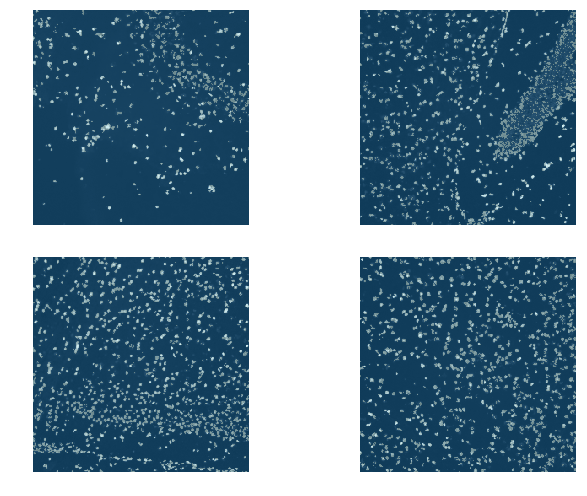

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [19]:
metrics=accuracy_thresh
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, model_dir = '/kaggle/working')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


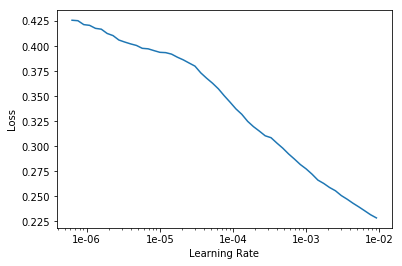

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=1e-3

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.203535,0.126556,0.503899,01:04
1,0.146985,0.093561,0.514672,01:02
2,0.118793,0.076366,0.505756,01:02
3,0.104274,0.073826,0.501388,01:02
4,0.095347,0.071439,0.519192,01:02
5,0.089134,0.066032,0.514136,01:03
6,0.085105,0.070886,0.501207,01:02
7,0.095296,0.071470,0.502310,01:02
8,0.088511,0.066549,0.499980,01:02
9,0.083592,0.064962,0.502232,01:02


In [24]:
learn.save('/kaggle/working/one_cycle')

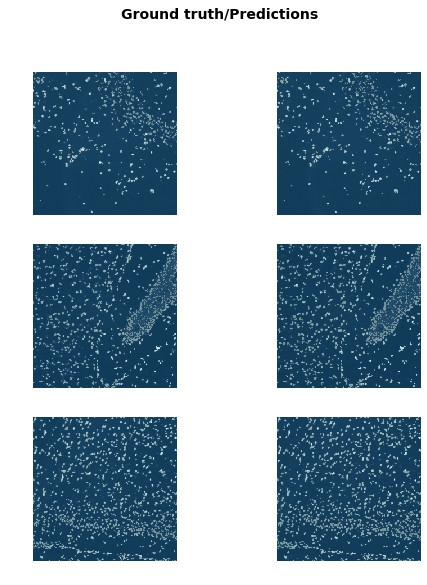

In [25]:
learn.show_results(rows=3, figsize=(8,9))

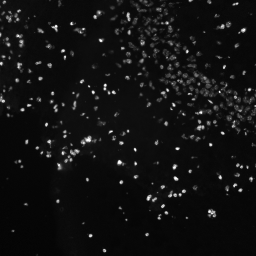

In [26]:
img = data.valid_ds[0][0]
img

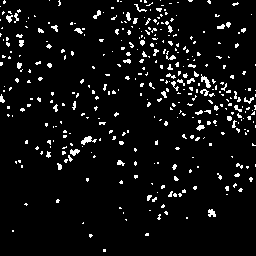

In [27]:
from PIL import Image
# img.show(y=learn.predict(img)[0])
prediction = learn.predict(img)
think_np = np.array(prediction[1])
think_np.shape = (256,256)
think_np = think_np.astype(int)
think_np[think_np > 0] = 255
think_im = Image.fromarray((think_np).astype('uint8'), mode='L')
think_im

In [28]:
# learn.destroy()

size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=1
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 15119MB of GPU RAM free


In [29]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, model_dir = '/kaggle/working')

In [31]:
# learn.load('/kaggle/working/one_cycle');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


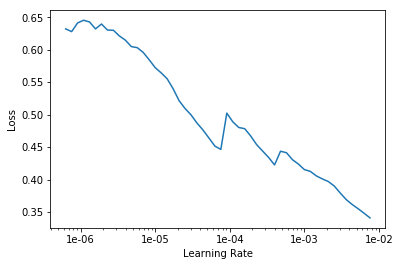

In [32]:
lr_find(learn)
learn.recorder.plot()

In [33]:
lr=1e-3

In [34]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.072619,0.055069,0.498577,02:18
1,0.066430,0.051922,0.497372,02:17
2,0.061899,0.046691,0.501607,02:17
3,0.065738,0.054493,0.497905,02:17
4,0.069105,0.048223,0.503667,02:17
5,0.061913,0.047906,0.501649,02:17
6,0.070763,0.051968,0.505182,02:16
7,0.062289,0.050678,0.498945,02:16
8,0.057695,0.048494,0.503810,02:17
9,0.052013,0.047750,0.498187,02:17


In [35]:
learn.save('one-cycle-big')
learn.save('one-cycle-big.pkl')

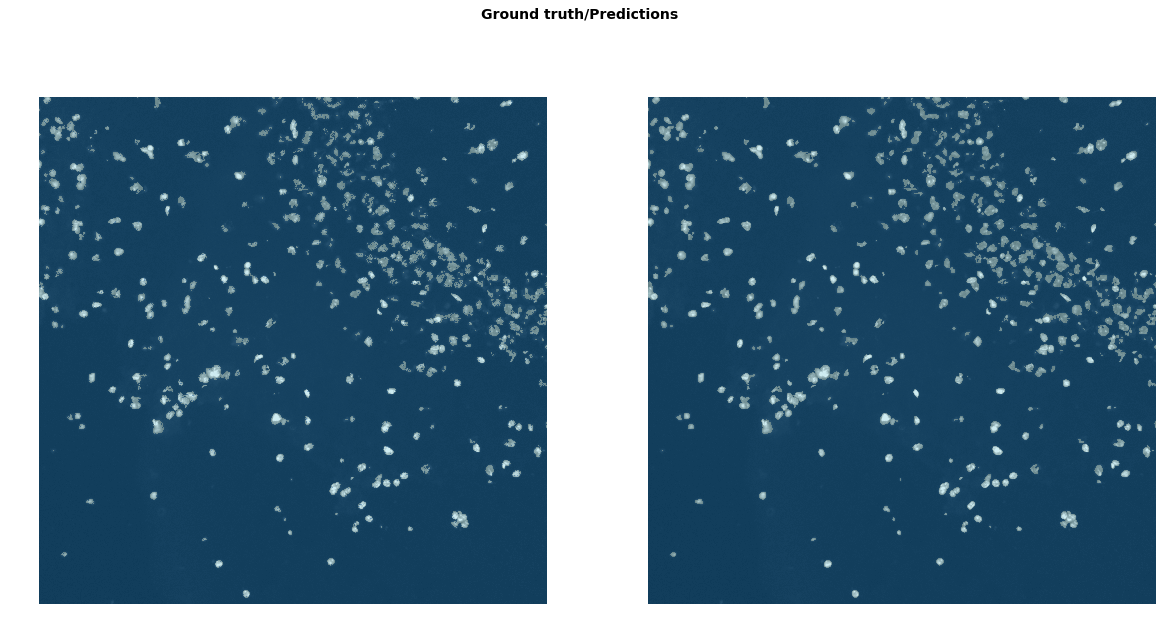

In [37]:
learn.show_results(rows=3, figsize=(20,10))

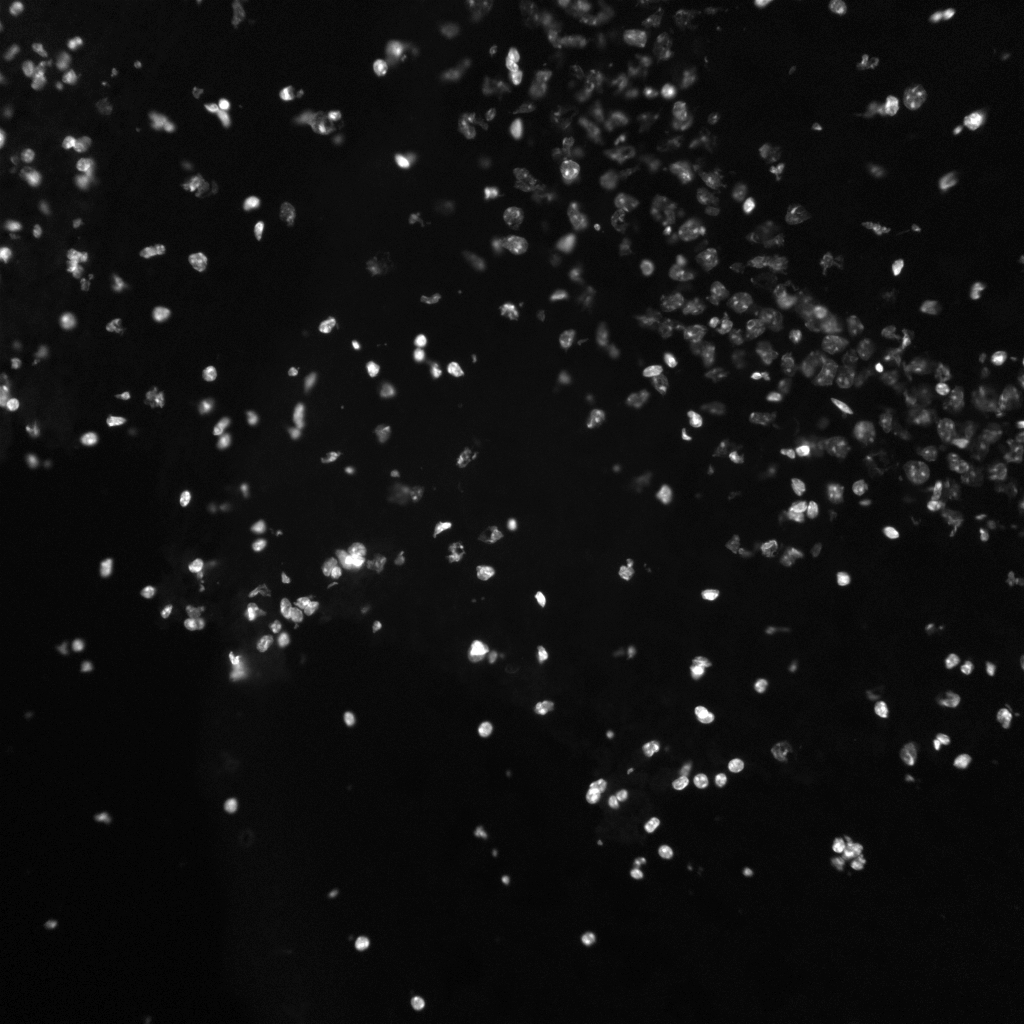

In [38]:
img = data.valid_ds[0][0]
img

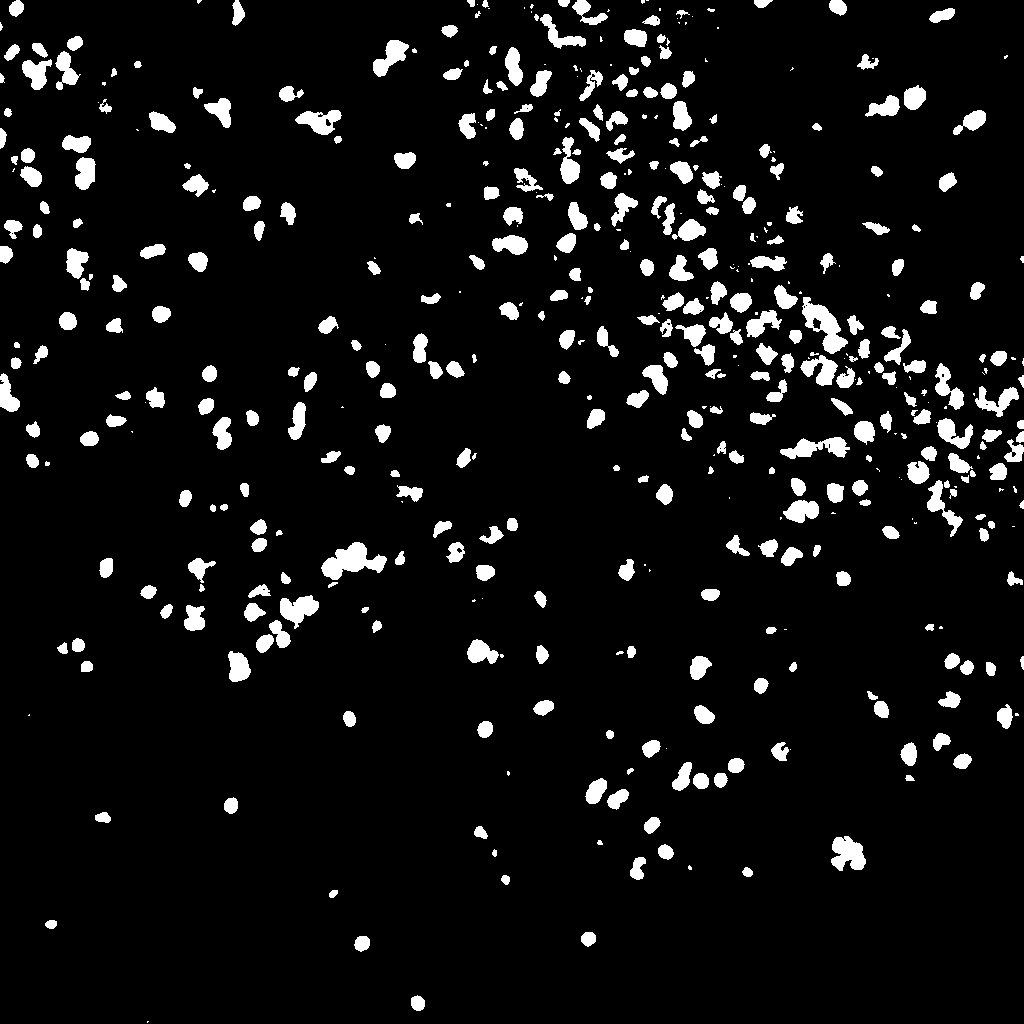

In [41]:
prediction = learn.predict(img)
think_np = np.array(prediction[1])
think_np.shape = (1024,1024)
think_np = think_np.astype(int)
think_np[think_np > 0] = 255
think_im = Image.fromarray((think_np).astype('uint8'), mode='L')
think_im

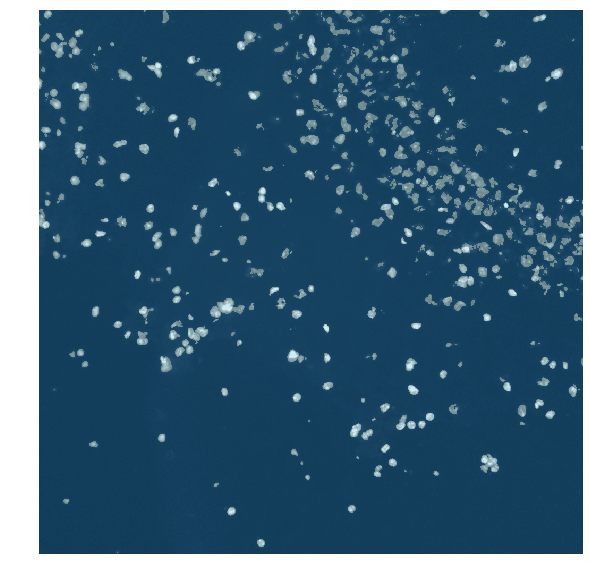

In [43]:
img.show(y=learn.predict(img)[0], figsize=(20,10))